### Tests

First tests of dbscans on a list of OCs

In [1]:
import sys, os
sys.path.append('../../src')

import astropy.coordinates as coord

from astropy.io.votable import parse
from astropy.table import Table
from astropy import units as u
from scipy.spatial.distance import pdist

import math

import matplotlib.pyplot as plt
from pylab import rcParams
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd

from math import ceil , pi , cos, sin
import gaia_utils as gu
from sklearn.cluster import KMeans

%matplotlib inline

## directory
rootdir = "/home/stephane/Science/GAIA"
wdir    = "%s/products"%(rootdir)
datadir = "%s/gaia-shock/notebooks/data"%(rootdir)

os.chdir(wdir)

#### Input Parameters########################################################
filelist = datadir+"/"+"BrowseTargets.18292.1530479692.gaia.selected.txt"
fileoutGaia = wdir + "/"+"BrowseTargets.18292.1530479692.gaia.dbscan.txt"

WEIGHT = np.ones(8)

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


In [2]:
from astroquery.gaia import Gaia

# tables = Gaia.load_tables(only_names=True)

#for table in (tables):
#    print (table.get_qualified_name())
    

In [3]:
## read the cluster list from HEASARC
def read_cluster_list(filelist):
    
    df = pd.read_csv(filelist, sep='|')
    
    return(df)

######
def init_SCgaia(filegaia, filelist):
    "init output if not there.."
    
    if not os.path.exists(filegaia):
        with open(filelist,"r") as f:
            header = f.readline()
        with open(filegaia,"w") as f:
            f.write(header)
    
#######
## write in fileoutGaia the selected cluster for GAIA
def write_SCgaia(filegaia, row):
    df = pd.DataFrame(row).T
    df.to_csv(filegaia,sep ="|", mode = "a", header= False, index = False)
    
    
######       
## find the last SC found.
def find_lastSC(filegaia,filelist, dfsc):
    if os.path.exists(filegaia):
        print(filegaia)
        dfcurrent = read_cluster_list(filegaia)
        last_cluster = dfcurrent['name'].iloc[[-1]].iloc[0]
        index = dfsc.index[dfsc['name'].str.contains(last_cluster)]
    else:
        init_SCgaia(filegaia, filelist)
        last_cluster = "No cluster"
        index = [0]
        
    return(last_cluster, index[0])

In [4]:
## plot results dbscans..

def plot2d(df, distsc,result, labels, ilab, cmap = "gist_stern" , figname = "test.dbscan.png", color = False):
    
    rcParams['figure.figsize'] = 14, 14
    f, axarr = plt.subplots(2, 2)
    
    if color:
        axarr[0,0].scatter(df[np.where(labels == ilab),0],df[np.where(labels == ilab),1],  s = 1.0, c= df[np.where(labels == ilab),2], cmap=cmap )
    else:
        axarr[0,0].scatter(df[np.where(labels == ilab),0],df[np.where(labels == ilab),1],  s = 1.0, c = "k")
    axarr[0,0].set_xlabel("X")
    axarr[0,0].set_ylabel("Y")
    
    axarr[1,0].scatter(df[np.where(labels == ilab),1],df[np.where(labels == ilab),2] , s=1.0, c= "k")
    axarr[1,0].set_xlabel("Y")
    axarr[1,0].set_ylabel("Z")
    
    
    axarr[0,1].scatter(df[np.where(labels == ilab),3],df[np.where(labels == ilab),4] , s= 1.0, c= df[np.where(labels == ilab),2], cmap=cmap)
    axarr[0,1].set_xlabel("Vdra")
    axarr[0,1].set_ylabel("Vdec")
    
    axarr[1,1].scatter(df[np.where(labels == ilab),6],df[np.where(labels == ilab),5] , s = 1.0, c= df[np.where(labels == ilab),2], cmap=cmap)
    axarr[1,1].set_xlabel("G-R")
    axarr[1,1].set_ylabel("G")
    axarr[1,1].set_xlim(-0.5,2.0)
    axarr[1,1].set_ylim(27.,10)
    
    ### properties
    nstars    = result['nstars'][ilab+1]
    posx      = result['pos'][ilab+1][0]
    posy      = result['pos'][ilab+1][1]
    posz      = result['pos'][ilab+1][2]
    velra     = result['vel'][ilab+1][0]
    veldec    = result['vel'][ilab+1][1]
    stdx      = result['pos_std'][ilab+1][0]
    stdy      = result['pos_std'][ilab+1][1]
    stdz      = result['pos_std'][ilab+1][2]
    stdvelra  = result['vel_std'][ilab+1][0] 
    stdveldec = result['vel_std'][ilab+1][1]
    
    txt = "Obs. dist: %3.1f pc"%(distsc)
    axarr[1,1].text(0.05, 0.05, txt, horizontalalignment='left',verticalalignment='center', transform=axarr[1,1].transAxes)
    txt = "N: %d"%(nstars)
    axarr[1,1].text(0.05, 0.10, txt, horizontalalignment='left',verticalalignment='center', transform=axarr[1,1].transAxes)
    txt = "X,Y,Z: %3.1f , %3.1f , %3.1f"%(posx,posy,posz)
    axarr[1,1].text(0.05, 0.15, txt, horizontalalignment='left',verticalalignment='center', transform=axarr[1,1].transAxes)
    txt = "Disp X,Y,Z: %3.1f , %3.1f , %3.1f"%(stdx,stdy,stdz)
    axarr[1,1].text(0.05, 0.20, txt, horizontalalignment='left',verticalalignment='center', transform=axarr[1,1].transAxes)
    txt = "Vel: %3.1f , %3.1f"%(velra, veldec)
    axarr[1,1].text(0.05, 0.25, txt, horizontalalignment='left',verticalalignment='center', transform=axarr[1,1].transAxes)
    txt = "Disp Vel: %3.1f , %3.1f"%(stdvelra, stdveldec)
    axarr[1,1].text(0.05, 0.30, txt, horizontalalignment='left',verticalalignment='center', transform=axarr[1,1].transAxes)
    txt = "Ell.: %3.1f , %3.1f"%(stdz / stdy, stdvelra / stdveldec)
    axarr[1,1].text(0.05, 0.35, txt, horizontalalignment='left',verticalalignment='center', transform=axarr[1,1].transAxes)
    
    
    plt.savefig(figname)
    
    plt.show()
  

def print_result(result, ilab):
    "print best result..."  
     
    nstars    = result['nstars'][ilab+1]
    posx      = result['pos'][ilab+1][0]
    posy      = result['pos'][ilab+1][1]
    posz      = result['pos'][ilab+1][2]
    velra     = result['vel'][ilab+1][0]
    veldec    = result['vel'][ilab+1][1]
    stdx      = result['pos_std'][ilab+1][0]
    stdy      = result['pos_std'][ilab+1][1]
    stdz      = result['pos_std'][ilab+1][2] 
    stdvelra  = result['vel_std'][ilab+1][0] 
    stdveldec = result['vel_std'][ilab+1][1]
    
    print("## Physical properties of the label %d"%(ilab))
    print("## Pos. mean (X, Y, Z): %4.2f , %4.2f , %4.2f"%(posx, posy, posz))
    print("## Disp. (X, Y, Z): %4.2f , %4.2f , %4.2f"%(stdx, stdy, stdz))
    print("##")
    print("## Vel. mean (RA,Dec): %4.2f , %4.2f"%(velra, veldec))
    print("## Vel. disp. (RA,Dec): %4.2f , %4.2f"%(stdvelra, stdveldec))
    print("##")
    print("## Ellipticities:")
    print("## Spatial (Y/X) (Z/X) (Z/Y) : (%4.2f) (%4.2f) (%4.2f)"%(stdy / stdx, stdz/stdx, stdz/stdy))
    print("## Vel. (RA/Dec) : %4.2f"%(stdvelra / stdveldec))  

In [5]:
def average_density_hyperspace(df):
    "compute the average density and distance"
    
    
    ndim = df.shape
    nstars = ndim[0]
    nbootstrap = 5000
    
    npts = df[np.random.randint(0,nstars, nbootstrap),:]
    dist = pdist(npts)
    distmin = np.min(dist[np.nonzero(dist)])
    distmean = np.mean(dist[np.nonzero(dist)])
    distmax = np.max(dist[np.nonzero(dist)])
    
    return(distmin, distmean, distmax)    

In [ ]:
def iter_dbscan(s, neps):
    "Range of the parameters for dbscan. The selection can be done either on Q or nstar and Q..."

        
    nstar_max = 0
    cluster_best = {}
    result_best = {}
    label_best = []
    ilab_best = []
    
    epsilon_best = 0.
    ilab_best = -1
    
    ###############
    res = average_density_hyperspace(source.dfcartnorm)
    print(res)
    min_samples = 15
    epsmin = res[0] * math.sqrt(min_samples)
    epsmax = epsmin * 1.1
    posxstdmax = 50.

    epsilon    = np.linspace(epsmin,epsmax, neps)
    
    for e in epsilon:
        print('.' , end="")
        labels_d, result = s.dbscan_(e, min_samples, cartesian = True)
        n_clusters_ = len(result['label']) -1
                        
        if n_clusters_ > 0:
            for nstar, lab , pos_std in zip(result['nstars'], result['label'], result['pos_std']):
                if  nstar > nstar_max and pos_std[0] < posxstdmax:
                    cluster_best = result
                    label_best = labels_d
                    ilab_best = lab
                    result_best = result
                    epsilon_best = e
                    nstar_max = nstar      
                    
                            
    print("\n## DBSCAN done!") 
    print("## Eps: %f "%(epsilon_best))

    # print(cluster_best)
    
    return(label_best, ilab_best, cluster_best, result_best, epsilon_best)

RangeIndex(start=0, stop=339, step=1)
Index(['Unnamed: 0', 'name', 'ra', 'dec', 'cluster_radius', 'rad_vel',
       'rad_vel_error', 'num_cluster_stars', 'distance', 'log_age',
       'log_age_error', 'Unnamed: 11'],
      dtype='object')
No cluster
#####################
## Cluster: MWSC 4688
## Distance: 1336.0 pc
##
## Starting DBSCAN optimization....
##
## Query radius: 2.0
SELECT * FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),                                      CIRCLE('ICRS',357.9750000000,-86.7200000000,2.0000000000)) = 1  AND abs(pmra_error/pmra)<  0.200000  AND abs(pmdec_error/pmdec)< 0.2000000000 AND abs(parallax_error/parallax)< 0.2000000000;
Launched query: 'SELECT * FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),                                      CIRCLE('ICRS',357.9750000000,-86.7200000000,2.0000000000)) = 1  AND abs(pmra_error/pmra)<  0.200000  AND abs(pmdec_er

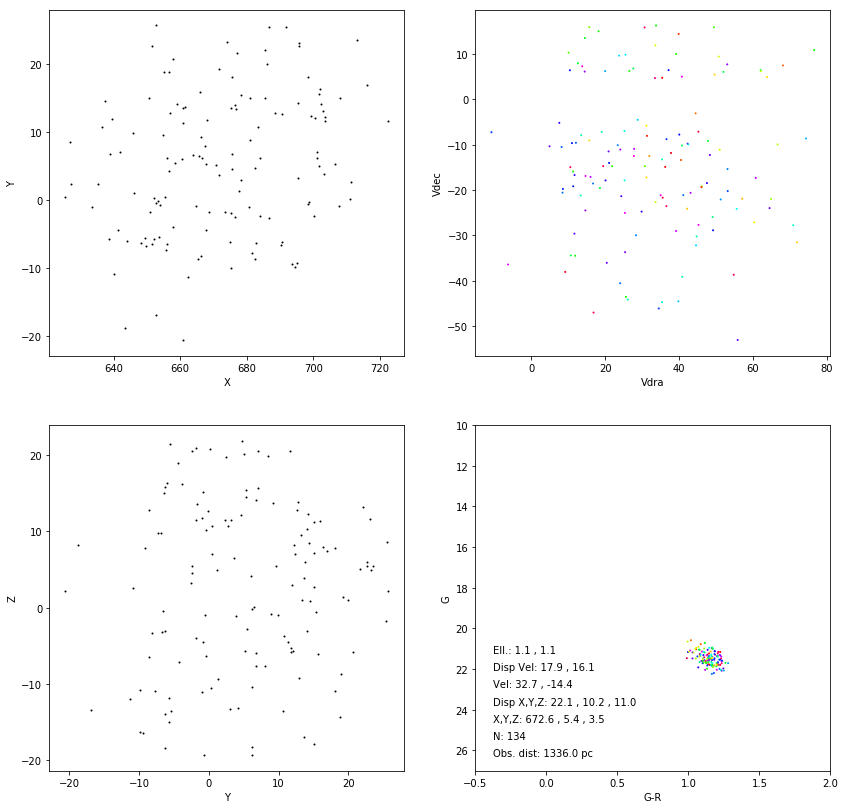

#####################
## Cluster: MWSC 5684
## Distance: 1432.0 pc
##
## Starting DBSCAN optimization....
##
## Query radius: 2.0
SELECT * FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),                                      CIRCLE('ICRS',193.4291666667,-86.6483333333,2.0000000000)) = 1  AND abs(pmra_error/pmra)<  0.200000  AND abs(pmdec_error/pmdec)< 0.2000000000 AND abs(parallax_error/parallax)< 0.2000000000;
Launched query: 'SELECT * FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),                                      CIRCLE('ICRS',193.4291666667,-86.6483333333,2.0000000000)) = 1  AND abs(pmra_error/pmra)<  0.200000  AND abs(pmdec_error/pmdec)< 0.2000000000 AND abs(parallax_error/parallax)< 0.2000000000;'
Retrieving async. results...
## MWSC 5684-2.0deg.vot created
## Query for MWSC 5684 done
## Total stars: 45788
## Conversion done...
## Stars selected: 35753
## Cartesian coord

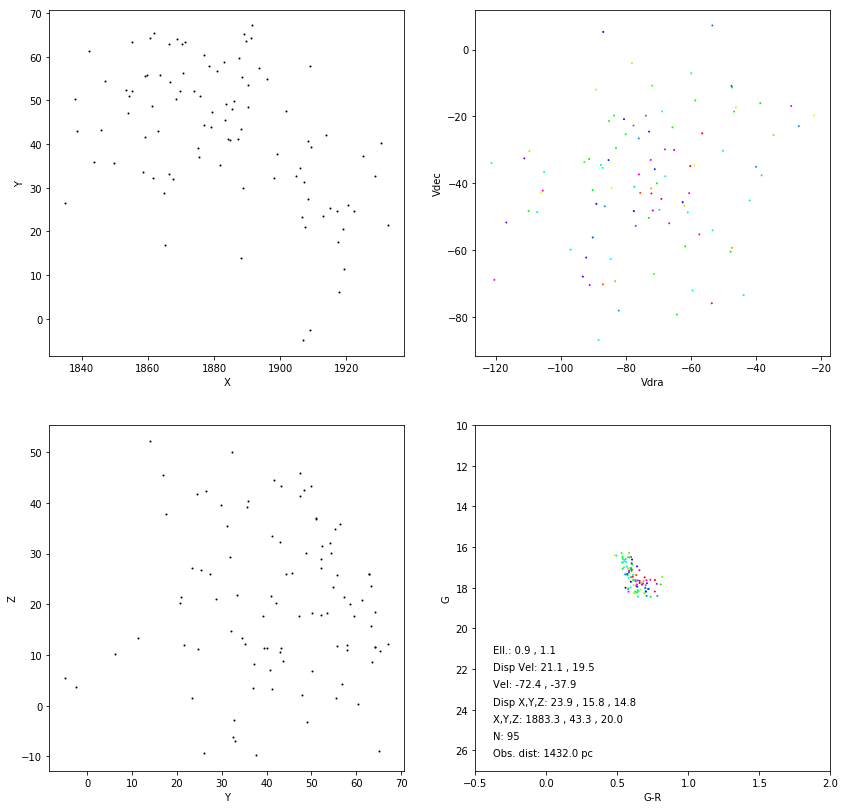

#####################
## Cluster: MWSC 4176
## Distance: 1093.0 pc
##
## Starting DBSCAN optimization....
##
## Query radius: 2.0
SELECT * FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),                                      CIRCLE('ICRS',216.8250000000,-85.4200000000,2.0000000000)) = 1  AND abs(pmra_error/pmra)<  0.200000  AND abs(pmdec_error/pmdec)< 0.2000000000 AND abs(parallax_error/parallax)< 0.2000000000;
Launched query: 'SELECT * FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),                                      CIRCLE('ICRS',216.8250000000,-85.4200000000,2.0000000000)) = 1  AND abs(pmra_error/pmra)<  0.200000  AND abs(pmdec_error/pmdec)< 0.2000000000 AND abs(parallax_error/parallax)< 0.2000000000;'
Retrieving async. results...
## MWSC 4176-2.0deg.vot created
## Query for MWSC 4176 done
## Total stars: 50745
## Conversion done...
## Stars selected: 39283
## Cartesian coord

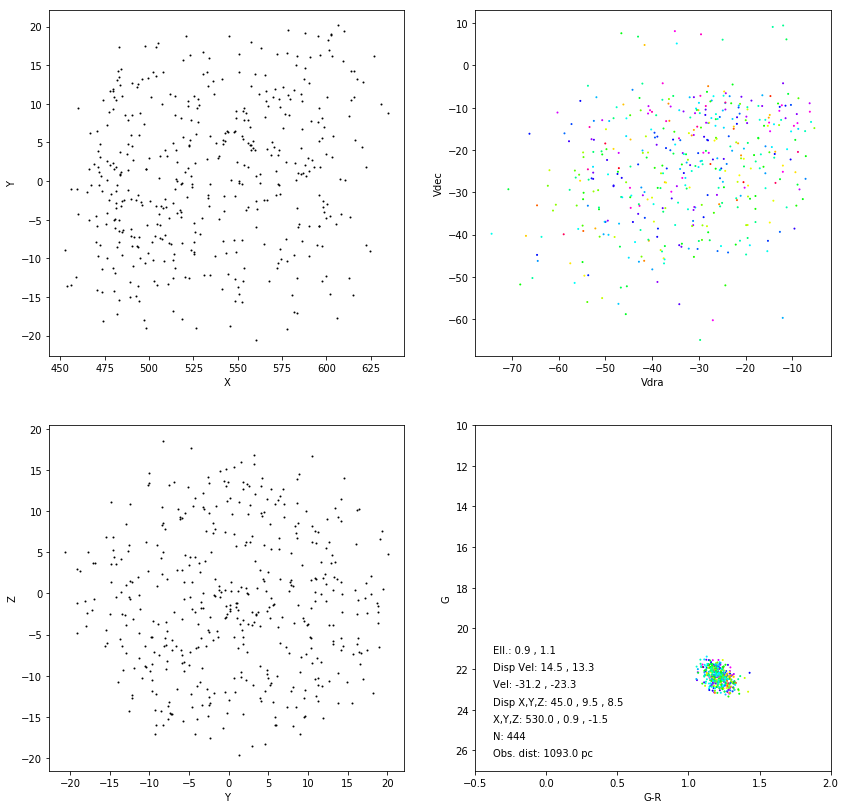

#####################
## Cluster: ESO 008-06
## Distance: 1380.0 pc
##
## Starting DBSCAN optimization....
##
## Query radius: 2.0
SELECT * FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),                                      CIRCLE('ICRS',224.2291666667,-83.4450000000,2.0000000000)) = 1  AND abs(pmra_error/pmra)<  0.200000  AND abs(pmdec_error/pmdec)< 0.2000000000 AND abs(parallax_error/parallax)< 0.2000000000;
Launched query: 'SELECT * FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),                                      CIRCLE('ICRS',224.2291666667,-83.4450000000,2.0000000000)) = 1  AND abs(pmra_error/pmra)<  0.200000  AND abs(pmdec_error/pmdec)< 0.2000000000 AND abs(parallax_error/parallax)< 0.2000000000;'
Retrieving async. results...
## ESO 008-06-2.0deg.vot created
## Query for ESO 008-06 done
## Total stars: 54703
## Conversion done...
## Stars selected: 42070
## Cartesian co

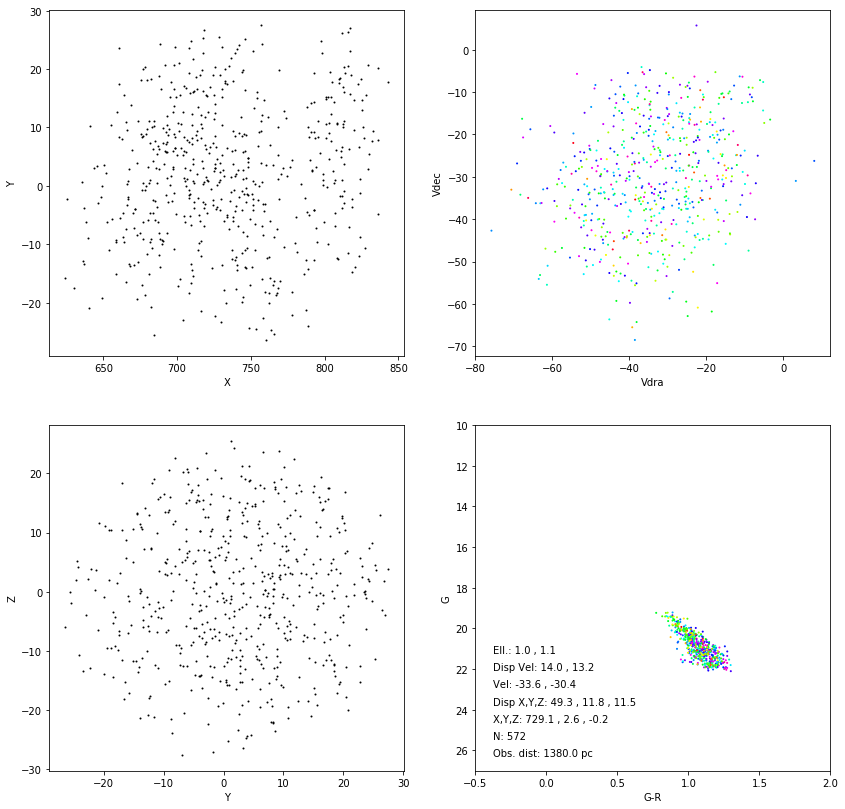

#####################
## Cluster: MWSC 4219
## Distance: 1606.0 pc
##
## Starting DBSCAN optimization....
##
## Query radius: 2.0
SELECT * FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),                                      CIRCLE('ICRS',235.5583333333,-83.1950000000,2.0000000000)) = 1  AND abs(pmra_error/pmra)<  0.200000  AND abs(pmdec_error/pmdec)< 0.2000000000 AND abs(parallax_error/parallax)< 0.2000000000;
Launched query: 'SELECT * FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),                                      CIRCLE('ICRS',235.5583333333,-83.1950000000,2.0000000000)) = 1  AND abs(pmra_error/pmra)<  0.200000  AND abs(pmdec_error/pmdec)< 0.2000000000 AND abs(parallax_error/parallax)< 0.2000000000;'
Retrieving async. results...
## MWSC 4219-2.0deg.vot created
## Query for MWSC 4219 done
## Total stars: 53039
## Conversion done...
## Stars selected: 41040
## Cartesian coord

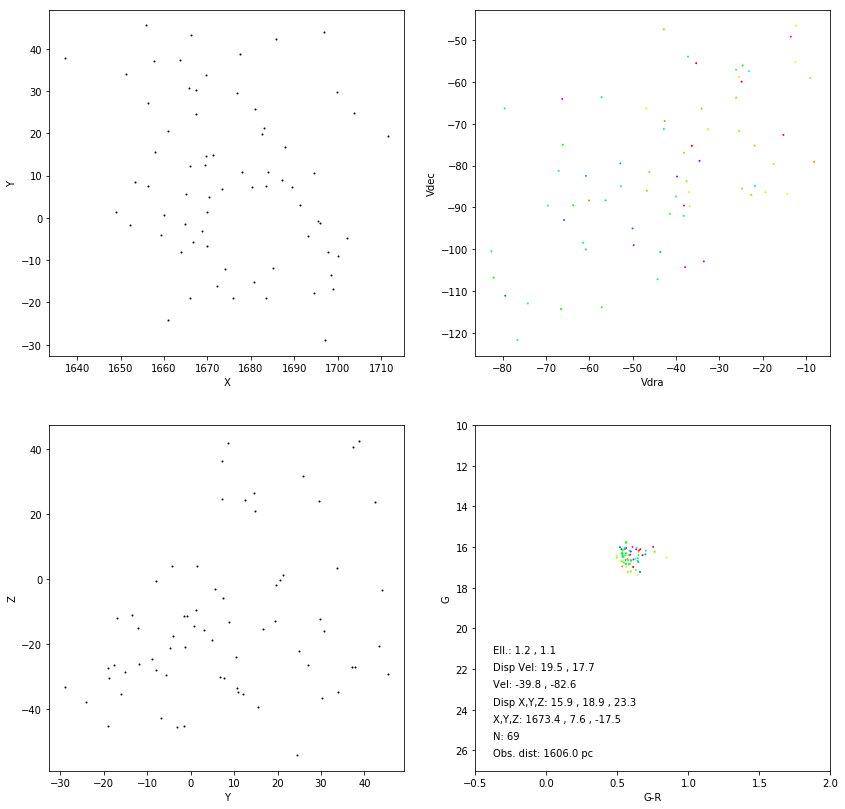

#####################
## Cluster: MWSC 4682
## Distance: 1065.0 pc
##
## Starting DBSCAN optimization....
##
## Query radius: 2.0
SELECT * FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),                                      CIRCLE('ICRS',355.8458333333,-82.9600000000,2.0000000000)) = 1  AND abs(pmra_error/pmra)<  0.200000  AND abs(pmdec_error/pmdec)< 0.2000000000 AND abs(parallax_error/parallax)< 0.2000000000;
Launched query: 'SELECT * FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),                                      CIRCLE('ICRS',355.8458333333,-82.9600000000,2.0000000000)) = 1  AND abs(pmra_error/pmra)<  0.200000  AND abs(pmdec_error/pmdec)< 0.2000000000 AND abs(parallax_error/parallax)< 0.2000000000;'
Retrieving async. results...
## MWSC 4682-2.0deg.vot created
## Query for MWSC 4682 done
## Total stars: 26315
## Conversion done...
## Stars selected: 21907
## Cartesian coord

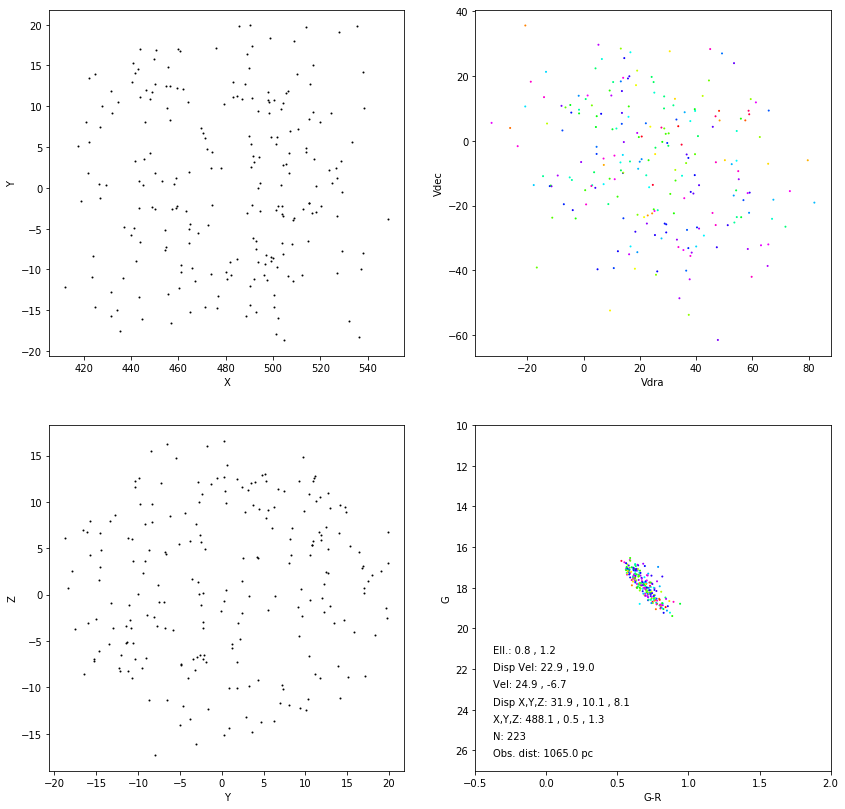

#####################
## Cluster: MWSC 5685
## Distance: 1581.0 pc
##
## Starting DBSCAN optimization....
##
## Query radius: 2.0
SELECT * FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),                                      CIRCLE('ICRS',196.3500000000,-82.0433333333,2.0000000000)) = 1  AND abs(pmra_error/pmra)<  0.200000  AND abs(pmdec_error/pmdec)< 0.2000000000 AND abs(parallax_error/parallax)< 0.2000000000;
Launched query: 'SELECT * FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),                                      CIRCLE('ICRS',196.3500000000,-82.0433333333,2.0000000000)) = 1  AND abs(pmra_error/pmra)<  0.200000  AND abs(pmdec_error/pmdec)< 0.2000000000 AND abs(parallax_error/parallax)< 0.2000000000;'
Retrieving async. results...
## MWSC 5685-2.0deg.vot created
## Query for MWSC 5685 done
## Total stars: 50975
## Conversion done...
## Stars selected: 39907
## Cartesian coord

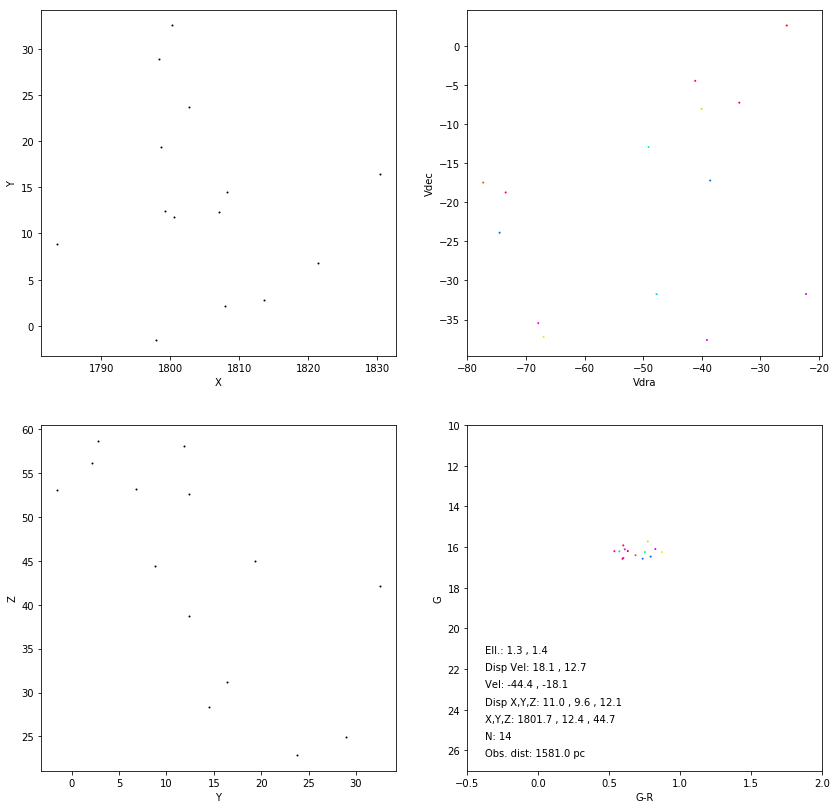

#####################
## Cluster: FSR 1631
## Distance: 1456.0 pc
##
## Starting DBSCAN optimization....
##
## Query radius: 2.0
SELECT * FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),                                      CIRCLE('ICRS',191.4291666667,-81.2583333333,2.0000000000)) = 1  AND abs(pmra_error/pmra)<  0.200000  AND abs(pmdec_error/pmdec)< 0.2000000000 AND abs(parallax_error/parallax)< 0.2000000000;
Launched query: 'SELECT * FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),                                      CIRCLE('ICRS',191.4291666667,-81.2583333333,2.0000000000)) = 1  AND abs(pmra_error/pmra)<  0.200000  AND abs(pmdec_error/pmdec)< 0.2000000000 AND abs(parallax_error/parallax)< 0.2000000000;'
Retrieving async. results...
## FSR 1631-2.0deg.vot created
## Query for FSR 1631 done
## Total stars: 50311
## Conversion done...
## Stars selected: 39478
## Cartesian coordina

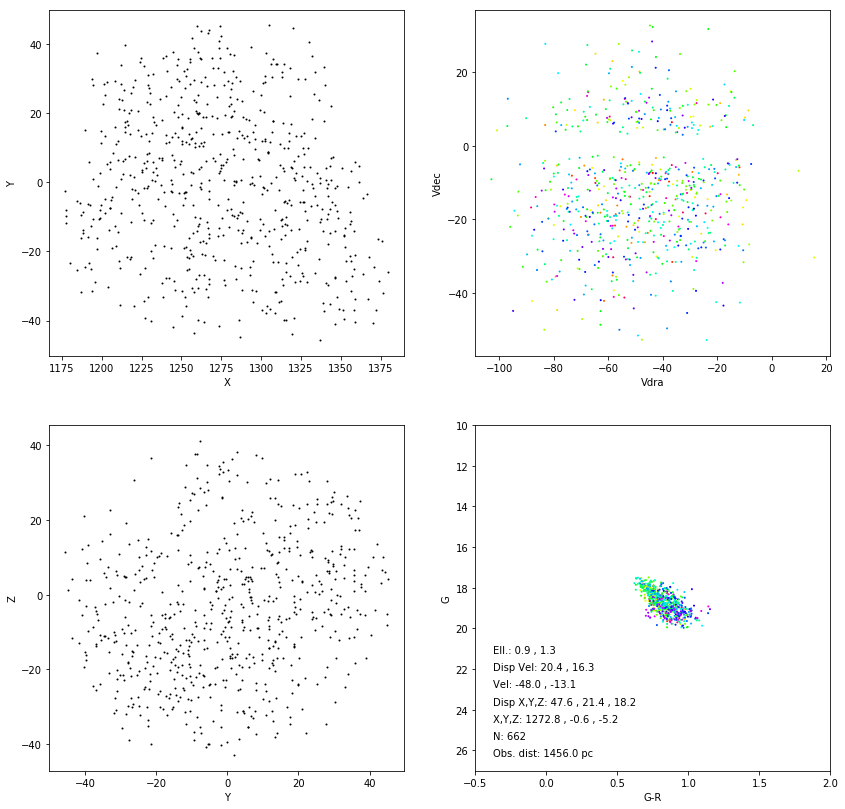

#####################
## Cluster: MWSC 4137
## Distance: 1209.0 pc
##
## Starting DBSCAN optimization....
##
## Query radius: 2.0
SELECT * FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),                                      CIRCLE('ICRS',141.5458333333,-79.7400000000,2.0000000000)) = 1  AND abs(pmra_error/pmra)<  0.200000  AND abs(pmdec_error/pmdec)< 0.2000000000 AND abs(parallax_error/parallax)< 0.2000000000;
Launched query: 'SELECT * FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),                                      CIRCLE('ICRS',141.5458333333,-79.7400000000,2.0000000000)) = 1  AND abs(pmra_error/pmra)<  0.200000  AND abs(pmdec_error/pmdec)< 0.2000000000 AND abs(parallax_error/parallax)< 0.2000000000;'
Retrieving async. results...


In [ ]:
###############################################################
######  Main loop
###############################################################

df_cluster = read_cluster_list(filelist)
print(df_cluster.index)
print(df_cluster.columns)

lastSC , lastrow = find_lastSC(fileoutGaia, filelist, df_cluster)

print(lastSC)

for index, row in df_cluster.iloc[lastrow:].iterrows():
    print("#####################")
    clustername = row['name'].strip()
    print("## Cluster: %s"%(clustername))
    print("## Distance: %3.1f pc"%(row['distance']))
    
    print("##")
    print("## Starting DBSCAN optimization....")
    print("##")
    
    rasplit = row['ra'].split(' ')
    decsplit = row['dec'].split(' ')
    racluster = "%sh%sm%ss"%(rasplit[0],rasplit[1],rasplit[2])
    deccluster = "%sd%sm"%(decsplit[0],decsplit[1])
    c = coord.SkyCoord(racluster, deccluster, frame='icrs')
    radius = float(row['cluster_radius'])
    RADIUS = max(2.0, radius * 3.5)
    aper = min(0.5, radius * 0.8)
    
    print("## Query radius: %3.1f"%(RADIUS))
    
    source = gu.source(clustername)
    source.weight = WEIGHT
    
    try:
        findCluster = True
        voname = source.query(RADIUS,  coordCluster = [c.ra.deg, c.dec.deg], errtol = 0.2, dump = True)
    # source.read_votable(voname)
    except:
        print("## GAIA query failed...")
        findCluster = False
        
    if findCluster:
        source.filter_data(mag_range = [0., 50])
        source.add_cartesian()

        block = [[0,1,2],[3,4],[5,6,7]]
        weightblock = [3.0, 2.0, 1.5]
        source.normalization_PerBlock(block, weightblock, cartesian = False ,norm = "averagestep")
        source.normalization_PerBlock(block, weightblock, cartesian = True , norm = "averagestep", density = True)


        labels_ , ilab_ , cluster_ , result_, eps_  = iter_dbscan(source , 10)
    
        if ilab_ != -1:
            print_result(result_, ilab_)
            figname = "%s-%3.1fdeg.dbscanBest.png"%(clustername,RADIUS)
            plot2d(source.dfcart, row['distance'], result_, labels_ , ilab_, cmap = "hsv" , figname = figname)


    write_SCgaia(fileoutGaia,row)
    
print("## Main loop done...")
